In [13]:
import os
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data import Dataset

# **Deep Convolutional GAN (DCGAN)**

In [14]:
# Hyperparameters
d_lr = 0.0001
g_lr = 0.0001
batch_size = 64
image_size = 64
nz = 100  # Latent vector size
num_epochs = 100
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for RGB images
])

# Load the Flowers102 dataset
train_dataset = datasets.Flowers102(root="./data", split="train", transform=transform, download=True)
test_dataset = datasets.Flowers102(root="./data", split="test", transform=transform, download=True)

# Combine train and test datasets
combined_dataset = ConcatDataset([train_dataset, test_dataset])
dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

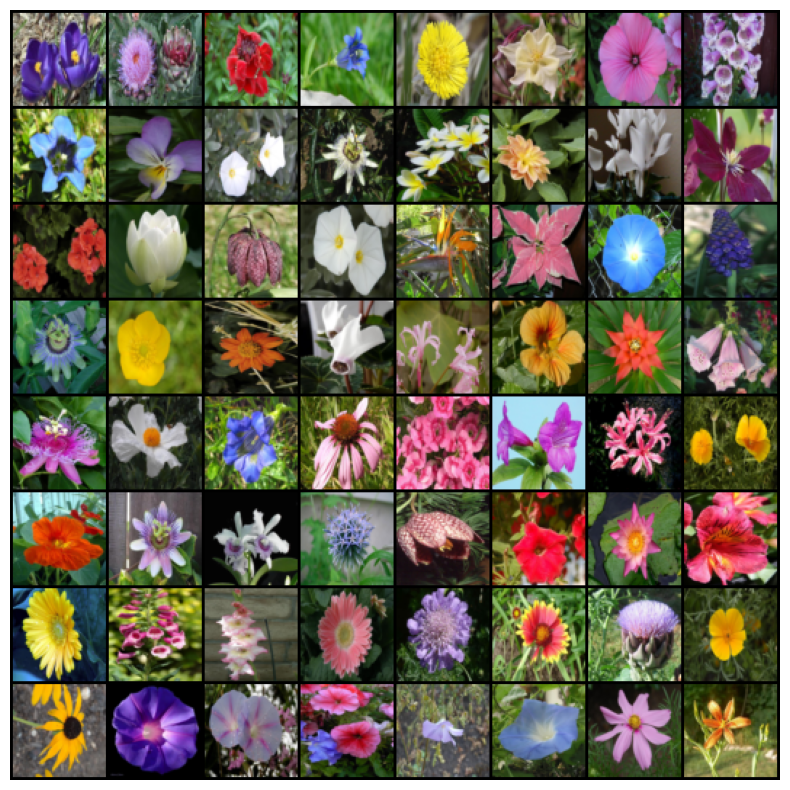

In [ ]:
# Visualizing real samples
real_batch = next(iter(dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1, 2, 0).cpu().numpy())
plt.show()

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: 3x64x64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),        # 32x32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),      # 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),      # 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),      # 4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),        # 1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1)  # Flatten to [batch_size, 1]

In [ ]:
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=g_lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=d_lr, betas=(0.5, 0.999))

#Log loss
g_loss_log = []
d_loss_log = []

In [ ]:
 # Training Loop
for epoch in range(num_epochs):
    g_losses = []
    d_losses = []

    with tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for i, (real_images, _) in pbar:
            real_images = real_images.to(device)
            current_batch_size = real_images.size(0)

            # Labels
            real_labels = torch.ones(current_batch_size, 1).to(device)
            fake_labels = torch.zeros(current_batch_size, 1).to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_outputs = discriminator(real_images)
            real_loss = criterion(real_outputs, real_labels)

            z = torch.randn(current_batch_size, nz, 1, 1).to(device)
            fake_images = generator(z)
            fake_outputs = discriminator(fake_images.detach())
            fake_loss = criterion(fake_outputs, fake_labels)

            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            fake_outputs = discriminator(fake_images)
            g_loss = criterion(fake_outputs, real_labels)
            g_loss.backward()
            optimizer_G.step()

            g_loss_log.append(g_loss.item())
            d_loss_log.append(d_loss.item())

            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())

            pbar.set_postfix(D_Loss=np.mean(d_losses), G_Loss=np.mean(g_losses))

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {np.mean(d_losses):.4f}, Loss G: {np.mean(g_losses):.4f}")

        # Save samples
        with torch.no_grad():
            z = torch.randn(16, nz, 1, 1).to(device)
            sample_images = generator(z)
            grid = vutils.make_grid(sample_images, normalize=True, scale_each=True)
            plt.figure(figsize=(10, 10))
            plt.axis("off")
            plt.title(f"Epoch {epoch} Generated Images")
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.show()

Epoch 1/100:   3%|▎         | 3/113 [00:15<09:27,  5.16s/it, D_Loss=0.923, G_Loss=2.13]


KeyboardInterrupt: 

# **Mode Collapse Example**

In [ ]:
nz = 100
num_epochs = 10

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: 3x64x64
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),        # 32x32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),      # 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),      # 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),      # 4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),      # 2x2
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 1, 2, 1, 0, bias=False),        # 1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1)  # Flatten to [batch_size, 1]

In [ ]:
# Transformations for FMNIST
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load train and test datasets
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Combine train and test datasets
combined_dataset = ConcatDataset([train_dataset, test_dataset])
dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Visualizing real samples
real_batch = next(iter(dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1, 2, 0).cpu().numpy())
plt.show()

In [ ]:
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=g_lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=d_lr, betas=(0.5, 0.999))

#Log loss
g_loss_log = []
d_loss_log = []

In [ ]:
 # Training Loop
for epoch in range(num_epochs):
    g_losses = []
    d_losses = []

    with tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for i, (real_images, _) in pbar:
            real_images = real_images.to(device)
            current_batch_size = real_images.size(0)

            # Labels
            real_labels = torch.ones(current_batch_size, 1).to(device)
            fake_labels = torch.zeros(current_batch_size, 1).to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_outputs = discriminator(real_images)
            real_loss = criterion(real_outputs, real_labels)

            z = torch.randn(current_batch_size, nz, 1, 1).to(device)
            fake_images = generator(z)
            fake_outputs = discriminator(fake_images.detach())
            fake_loss = criterion(fake_outputs, fake_labels)

            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            fake_outputs = discriminator(fake_images)
            g_loss = criterion(fake_outputs, real_labels)
            g_loss.backward()
            optimizer_G.step()

            g_loss_log.append(g_loss.item())
            d_loss_log.append(d_loss.item())

            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())

            pbar.set_postfix(D_Loss=np.mean(d_losses), G_Loss=np.mean(g_losses))

    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {np.mean(d_losses):.4f}, Loss G: {np.mean(g_losses):.4f}")

        # Save samples
        with torch.no_grad():
            z = torch.randn(16, nz, 1, 1).to(device)
            sample_images = generator(z)
            grid = vutils.make_grid(sample_images, normalize=True, scale_each=True)
            plt.figure(figsize=(10, 10))
            plt.axis("off")
            plt.title(f"Epoch {epoch} Generated Images")
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.show()

In [ ]:
with torch.no_grad():
    z = torch.randn(64, nz, 1, 1).to(device)
    sample_images = generator(z)
    grid = vutils.make_grid(sample_images, normalize=True, scale_each=True)
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title(f"Epoch {epoch} Generated Images")
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.show()

In [ ]:
from google.colab import files

uploaded = files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!ls /content/drive